# Visualize excess all-cause deaths in the USA during the COVID-19 pandemic by race.

Created by Reese Richardson (rakr@u.northwestern.edu)

3-29-21

Image series by exporting individuals frames, which were later combined into MP4 with ffmpeg.
Combo images were run at 33 FPS (-r 33) and individual race/ethnicity plots were run at 10 FPS (-r 10).
```
ffmpeg -r 33 -f image2 -i ./temp/%d.jpg -vcodec libx264 -crf 25 -pix_fmt yuv420p ./mp4/vertical_0.mp4
```
MP4 was converted to GIF with [CloudConvert.](https://cloudconvert.com/mp4-to-gif)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
import datetime
#sns.set(color_codes=True)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import statistics as st
sns.set_style('whitegrid', {'axes.linewidth' : 0.5})
from statsmodels.distributions.empirical_distribution import ECDF
import scipy
import gc
import statsmodels.api as sm
from IPython.display import clear_output
import os

### Data from Centers for Disease Control and Prevention - National Center for Health Statistics.
[Download Here.](https://data.cdc.gov/NCHS/Weekly-counts-of-deaths-by-jurisdiction-and-race-a/qfhf-uhaa)

In [9]:
df = pd.read_csv('./data/Weekly_Counts_of_Deaths_by_Jurisdiction__and_Race_and_Hispanic_Origin.csv')

In [10]:
df = df[(df['Jurisdiction'] == 'United States') & (df['Outcome'] == 'All Cause') & (df['Type'] == 'Predicted (weighted)')].reset_index(drop=True)

In [11]:
df['Week Ending Date'] = pd.to_datetime(df['Week Ending Date'])

### Axis initialization functions:

In [12]:
def initialize_axis(ax, race_df='Non-Hispanic Black', race_title='Non-Hispanic Black', 
                    high_val=60000, label_mode='ten_thousands', divisions=5):
    data = df[df['Race/Ethnicity'] == race_df].sort_values('Week Ending Date')[1:-1]
    x = (data['Week Ending Date'] - pd.to_datetime('2014-01-1')).dt.days
    x = -x/365*np.pi*2 + np.pi/2
    y = data['Number of Deaths']

    highest_val_to_display = high_val
    bottom = highest_val_to_display/1.25
    
    points = np.array([x, y+bottom]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    segments = segments
    lc = mpl.collections.LineCollection(segments, cmap=plt.get_cmap('coolwarm_r'), zorder=0, alpha=0)
    lc.set_linewidth(3)
    lc.set_array(f)
    lc_ax = ax.add_collection(lc)
    
    labels_0 = []
    if label_mode == 'ten_thousands':
        for lab in np.arange(0,highest_val_to_display,highest_val_to_display/divisions)/1000:
            labels_0.append(str(int(lab)) + 'k')
        ax.set_yticks(ticks=np.arange(bottom,highest_val_to_display+bottom,(highest_val_to_display)/divisions))
        ax.set_yticklabels(labels=labels_0, fontsize=fontsize+2, ha='center')
    elif label_mode == 'thousands':
        for lab in np.arange(0,highest_val_to_display,1000)/1000:
            labels_0.append(str(int(lab)) + 'k')
        ax.set_yticks(ticks=np.arange(bottom,highest_val_to_display+bottom,1000))
        ax.set_yticklabels(labels=labels_0, fontsize=fontsize+2, ha='center')
    elif label_mode == 'hundreds':
        for lab in np.arange(0,highest_val_to_display,highest_val_to_display/divisions):
            labels_0.append(str(int(lab)))
        ax.set_yticks(ticks=np.arange(bottom,highest_val_to_display+bottom,highest_val_to_display/divisions))
        ax.set_yticklabels(labels=labels_0, fontsize=fontsize+2, ha='center')
        
    text = ax.text(x=0, y=0, s=str(2014), ha='center', fontsize=28, va='center')
    mark = ax.scatter(x=x.values[1], y=y.values[1]+bottom, color='k')
    ax.set_title(race_title, fontsize=20, pad=0)
    ax.set_ylim([bottom,highest_val_to_display+bottom])
    ax.set_rlabel_position(90)
    ax.set_xticks(ticks=(np.arange(np.pi*2/12,np.pi*2,np.pi*2/12)+np.pi/2)%(np.pi*2))
    ax.set_xticklabels([])
    ax.set_rorigin(0)
    ax.spines['inner'].set_color('k')
    ax.spines['inner'].set_linewidth(1.5)

    for pos_x, rotation, label in zip(-theta_months+(np.pi/2), rotations, months):
        lab = ax.text(pos_x, bottom*0.8 , label, 
                 ha='center', va='center', rotation=rotation, rotation_mode="anchor", fontsize=fontsize)
    return {'ax':ax, 'x':x, 'y':y, 'bottom':bottom, 'text':text, 'mark':mark, 'lc_ax':lc_ax}

In [13]:
def initialize_axis_relative(ax, race_df='Non-Hispanic Black', race_title='Non-Hispanic Black', 
                    high_val=60000, label_mode='ten_thousands', divisions=5):
    data = df[df['Race/Ethnicity'] == race_df].sort_values('Week Ending Date')[1:-1].reset_index(drop=True)
    
    #As of 3/29/21, percent excess for the first week of 2021 appears to be miscalculated.
    #The line below applies a correction.
    data.at[364, 'Percent Difference from 2015-2019 to 2020'] = \
    "{:.1f}".format(100*((data.at[364, 'Number of Deaths'])/ \
                         (data.at[364, 'Number of Deaths']-data.at[363, 'Difference from 2015-2019 to 2020']))-100)
    
    data.at[364, 'Difference from 2015-2019 to 2020'] = data.at[363, 'Difference from 2015-2019 to 2020']
    
    x = (data['Week Ending Date'] - pd.to_datetime('2014-01-1')).dt.days
    x = -x/365*np.pi*2 + np.pi/2
    y = data['Percent Difference from 2015-2019 to 2020']

    highest_val_to_display = 200
    bottom = 200
    offset = 50
        
    points = np.array([x, y+bottom]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    segments = segments
    lc = mpl.collections.LineCollection(segments, cmap=plt.get_cmap('rainbow'), zorder=0, alpha=0)
    lc.set_linewidth(3)
    lc.set_array(f)
    lc_ax = ax.add_collection(lc)
    
    labels_0 = []
    for lab in np.arange(-offset,200,50):
        labels_0.append(str(int(lab)) + '%')
    ax.set_yticks(ticks=np.arange(bottom,highest_val_to_display+bottom,50))
    ax.set_yticklabels(labels=labels_0, fontsize=fontsize+2, ha='center')
        
    text = ax.text(x=0, y=0, s=str(2014), ha='center', fontsize=28, va='center')
    mark = ax.scatter(x=x.values[1], y=y.values[1]+bottom+offset, color='k')
    ax.set_title(race_title, fontsize=20, pad=0)
    ax.set_ylim([bottom,highest_val_to_display+bottom])
    
    rads = np.arange(0,np.pi*2+0.05,0.1)
    ax.plot(rads, np.ones(len(rads))*(bottom+offset), linewidth=1.5, c='k')
    
    ax.set_rlabel_position(90)
    ax.set_xticks(ticks=(np.arange(np.pi*2/12,np.pi*2,np.pi*2/12)+np.pi/2)%(np.pi*2))
    ax.set_xticklabels([])
    ax.set_rorigin(0)
    #ax.spines['inner'].set_color('k')
    #ax.spines['inner'].set_linewidth(1.5)

    for pos_x, rotation, label in zip(-theta_months+(np.pi/2), rotations, months):
        lab = ax.text(pos_x, bottom*0.8 , label, 
                 ha='center', va='center', rotation=rotation, rotation_mode="anchor", fontsize=fontsize+2)
    return {'ax':ax, 'x':x, 'y':y, 'bottom':bottom, 'text':text, 'mark':mark, 'lc_ax':lc_ax, 'offset':offset, 'data':data}

### Vertical combo GIF:

550
CPU times: total: 8min 45s
Wall time: 8min 46s


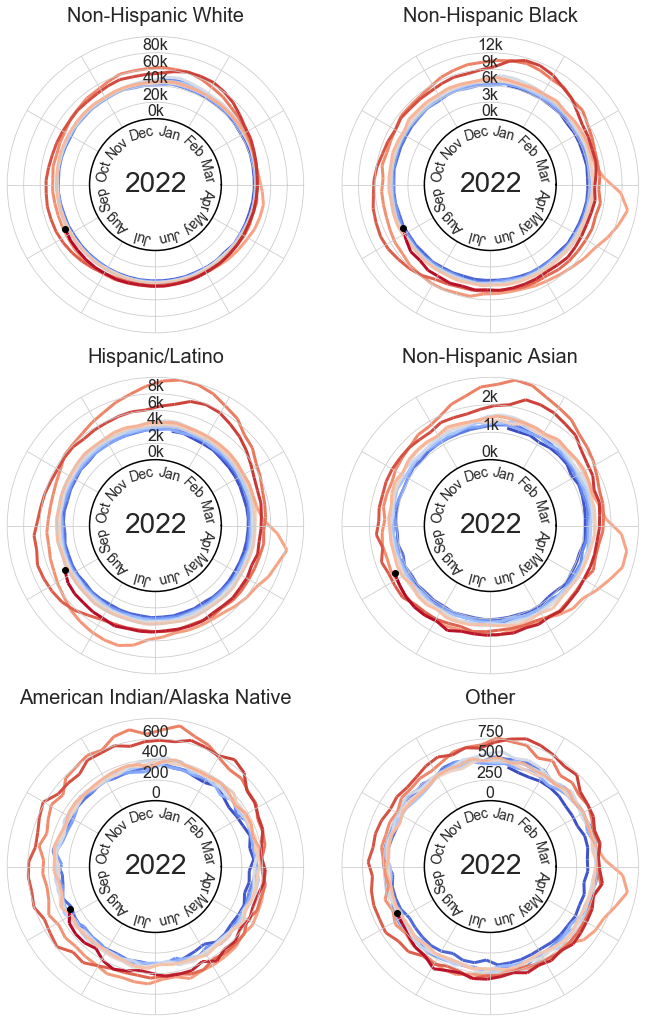

In [22]:
%%time
my_dpi = 96

fig, axes = plt.subplots(3,2,figsize=(12,18),subplot_kw={'projection': 'polar'}, gridspec_kw={'wspace':0.0, 'hspace':0.15})
fontsize=14
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

total_angle = np.pi*2
delt_months = total_angle/12
open_angle = 0
theta_months=np.arange(0+delt_months/2+open_angle/2, total_angle+delt_months/2+open_angle/2, delt_months)
rotations = np.rad2deg(-theta_months)

data = df[df['Race/Ethnicity'] == 'Non-Hispanic Black'].sort_values('Week Ending Date')[1:-1]
f = (data['Week Ending Date'] - pd.to_datetime('2014-01-1')).dt.days
f = -f/365*np.pi*2 + np.pi/2 

data_list = []
data_list.append(initialize_axis(ax=axes[0,0], race_df='Non-Hispanic White', 
                                 race_title='Non-Hispanic White', high_val=100000))
data_list.append(initialize_axis(ax=axes[0,1], race_df='Non-Hispanic Black', 
                                 race_title='Non-Hispanic Black', high_val=15000))
data_list.append(initialize_axis(ax=axes[1,0], race_df='Hispanic', 
                                 race_title='Hispanic/Latino', high_val=10000))
data_list.append(initialize_axis(ax=axes[1,1], race_df='Non-Hispanic Asian', 
                                 race_title='Non-Hispanic Asian', high_val=3000, 
                                 label_mode='thousands'))
data_list.append(initialize_axis(ax=axes[2,0], race_df='Non-Hispanic American Indian or Alaska Native', 
                                 race_title='American Indian/Alaska Native', high_val=800,
                                 label_mode='hundreds', divisions=4))
data_list.append(initialize_axis(ax=axes[2,1], race_df='Other', 
                                 race_title='Other', high_val=1000, 
                                 label_mode='hundreds', divisions=4))

for i in range(len(data_list[0]['x'])+(3*33)): #Full range +3 seconds pause on last frame = 462
    clear_output(wait=True)
    save_i = i
    for data_ele in data_list:
        if int(i) > len(data_ele['x'])-2:
            i = len(data_ele['x'])-2
        data_ele['lc_ax'].remove()
        
        points = np.array([data_ele['x'].values[0:i+2], 
                           data_ele['y'].values[0:i+2]+data_ele['bottom']]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        segments = segments
        lc = mpl.collections.LineCollection(segments, cmap=plt.get_cmap('coolwarm_r'), zorder=0, alpha=1)
        lc.set_linewidth(3)
        lc.set_array(f)
        data_ele['lc_ax'] = data_ele['ax'].add_collection(lc)
        
        data_ele['mark'].set_offsets([data_ele['x'].values[i+1], data_ele['y'].values[i+1]+data_ele['bottom']])
        data_ele['text'].set_text(str(2014+int((-list(data_ele['x'])[i]+np.pi/2)/(2*np.pi))))
    plt.savefig('temp/' + str(save_i) + '.jpg', dpi=my_dpi, quality=70, optimize=True, bbox_inches='tight', pad_inches=0.1)
    print(save_i)

### Horizontal combo GIF:

550
CPU times: total: 8min 38s
Wall time: 8min 38s


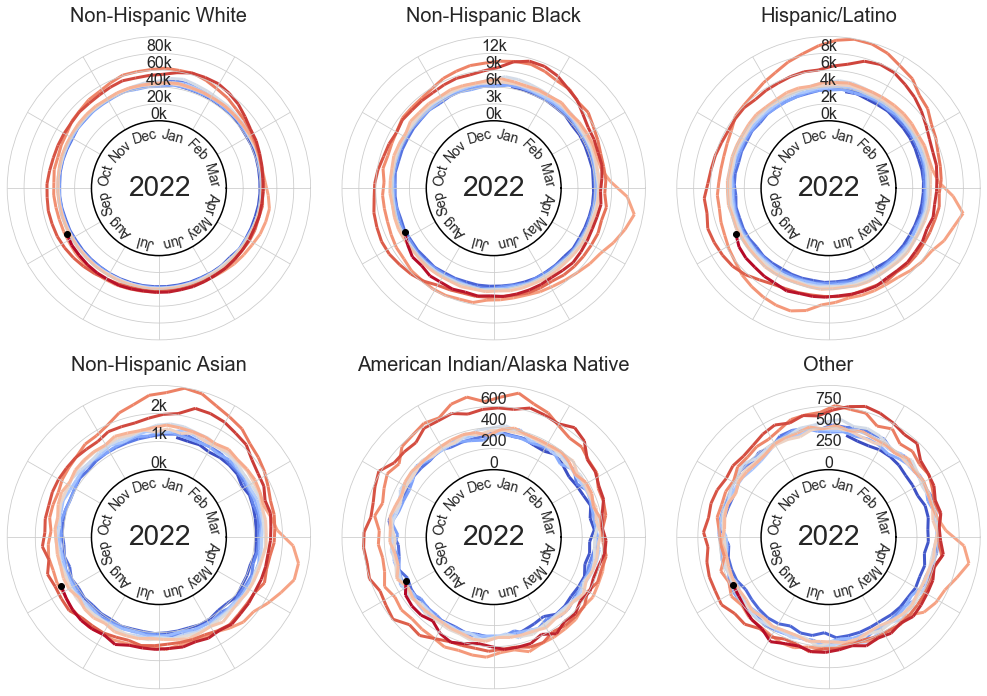

In [24]:
%%time
my_dpi = 90

fig, axes = plt.subplots(2,3,figsize=(18,12),subplot_kw={'projection': 'polar'}, gridspec_kw={'wspace':0.0, 'hspace':0.15})
fontsize=14
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

total_angle = np.pi*2
delt_months = total_angle/12
open_angle = 0
theta_months=np.arange(0+delt_months/2+open_angle/2, total_angle+delt_months/2+open_angle/2, delt_months)
rotations = np.rad2deg(-theta_months)

data = df[df['Race/Ethnicity'] == 'Non-Hispanic Black'].sort_values('Week Ending Date')[1:-1]
f = (data['Week Ending Date'] - pd.to_datetime('2014-01-1')).dt.days
f = -f/365*np.pi*2 + np.pi/2

data_list = []
data_list.append(initialize_axis(ax=axes.flatten()[0], race_df='Non-Hispanic White', 
                                 race_title='Non-Hispanic White', high_val=100000))
data_list.append(initialize_axis(ax=axes.flatten()[1], race_df='Non-Hispanic Black', 
                                 race_title='Non-Hispanic Black', high_val=15000))
data_list.append(initialize_axis(ax=axes.flatten()[2], race_df='Hispanic', 
                                 race_title='Hispanic/Latino', high_val=10000))
data_list.append(initialize_axis(ax=axes.flatten()[3], race_df='Non-Hispanic Asian', 
                                 race_title='Non-Hispanic Asian', high_val=3000, 
                                 label_mode='thousands'))
data_list.append(initialize_axis(ax=axes.flatten()[4], race_df='Non-Hispanic American Indian or Alaska Native', 
                                 race_title='American Indian/Alaska Native', high_val=800,
                                 label_mode='hundreds', divisions=4))
data_list.append(initialize_axis(ax=axes.flatten()[5], race_df='Other', 
                                 race_title='Other', high_val=1000, 
                                 label_mode='hundreds', divisions=4))

for i in range(len(data_list[0]['x'])+(3*33)): #Full range +3 seconds pause on last frame = 462
    clear_output(wait=True)
    save_i = i
    for data_ele in data_list:
        if int(i) > len(data_ele['x'])-2:
            i = len(data_ele['x'])-2
        #data_ele['ax'].plot(data_ele['x'][i:i+2], data_ele['y'][i:i+2]+data_ele['bottom'], 
        #        linewidth=2, color=mpl.cm.coolwarm(i/(len(x)-2)))
        data_ele['lc_ax'].remove()
        
        points = np.array([data_ele['x'].values[0:i+2], 
                           data_ele['y'].values[0:i+2]+data_ele['bottom']]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        segments = segments
        lc = mpl.collections.LineCollection(segments, cmap=plt.get_cmap('coolwarm_r'), zorder=0, alpha=1)
        lc.set_linewidth(3)
        lc.set_array(f)
        data_ele['lc_ax'] = data_ele['ax'].add_collection(lc)
        
        data_ele['mark'].set_offsets([data_ele['x'].values[i+1], data_ele['y'].values[i+1]+data_ele['bottom']])
        data_ele['text'].set_text(str(2014+int((-list(data_ele['x'])[i]+np.pi/2)/(2*np.pi))))
    plt.savefig('temp/' + str(save_i) + '.jpg', dpi=my_dpi, quality=70, optimize=True, bbox_inches='tight', pad_inches=0.1)
    print(save_i)

### Relative plots by individual race/ethnicity:

#### Non-Hispanic White

469
CPU times: total: 32.4 s
Wall time: 32.2 s


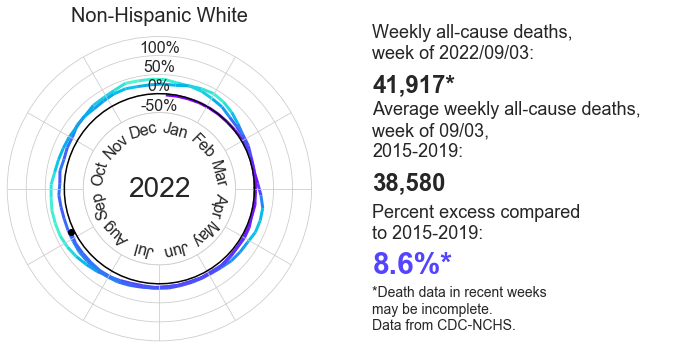

In [30]:
%%time
my_dpi = 99
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, polar=True)
ax2 = fig.add_subplot(122)
axes.flatten()[0]
data_list = []
data_list.append(initialize_axis_relative(ax=ax1, race_df='Non-Hispanic White', 
                                 race_title='Non-Hispanic White', high_val=100))

offset = 0.05
date = pd.to_datetime(data_list[0]['data']['Week Ending Date'].values[312])

weekly = data_list[0]['data']['Number of Deaths'].values[312]
expected = weekly - data_list[0]['data']['Difference from 2015-2019 to 2020'].values[312]
excess = data_list[0]['data']['Percent Difference from 2015-2019 to 2020'].values[312]

weekly_title = ax2.text(s='Weekly all-cause deaths,\nweek of ' + date.strftime("%Y/%m/%d") + ':',
                  x=0,y=0.85+offset, fontsize=18)
weekly_deaths = ax2.text(s=str(int(weekly)), x=0, y=0.75+offset, fontsize=24, fontweight='semibold')
expected_title = ax2.text(s='Average weekly all-cause deaths,\nweek of '+ date.strftime("%m/%d") + ',\n2015-2019:',
                    x=0, y=0.55+offset, fontsize=18)
expected_deaths = ax2.text(s=str(int(expected)), x=0, y=0.45+offset, fontsize=24, fontweight='semibold')
excess_title = ax2.text(s='Percent excess compared\nto 2015-2019:',
                    x=0, y=0.30+offset, fontsize=18)
excess_deaths = ax2.text(s=str(excess)+'%', x=0, y=0.19+offset, fontsize=30, 
                         color=plt.get_cmap('rainbow')(excess/100), fontweight='bold')
disclaimer = ax2.text(s='*Death data in recent weeks\nmay be incomplete.\nData from CDC-NCHS.',
                     x=0,y=0.02+offset, fontsize=14)
ax2.axis('off')

start_frame = 312 #312 starts at beginning of 2020.

for i in range(start_frame, len(data_list[0]['x'])+18): #Full range + ~2 seconds at 10 FPS
    clear_output(wait=True)
    save_i = i
    if i > len(data_list[0]['x'])-10:
        addendum = '*'
    else:
        addendum = ''
        
    for data_ele in data_list:
        
        
        if int(i) > len(data_ele['x'])-2:
            i = len(data_ele['x'])-2
        data_ele['lc_ax'].remove()
        
        date = pd.to_datetime(data_list[0]['data']['Week Ending Date'].values[i+1])
        weekly = data_list[0]['data']['Number of Deaths'].values[i+1]
        expected = weekly - data_list[0]['data']['Difference from 2015-2019 to 2020'].values[i+1]
        excess = data_list[0]['data']['Percent Difference from 2015-2019 to 2020'].values[i+1]
        
        weekly_title.set_text(s='Weekly all-cause deaths,\nweek of ' + date.strftime("%Y/%m/%d") + ':')
        weekly_deaths.set_text(s='{:,}'.format(int(weekly))+addendum)
        expected_title.set_text(s='Average weekly all-cause deaths,\nweek of '+ date.strftime("%m/%d") + ',\n2015-2019:')
        expected_deaths.set_text(s='{:,}'.format(int(expected)))
        excess_title.set_text(s='Percent excess compared\nto 2015-2019:')
        excess_deaths.set_text(s=str(excess)+'%'+addendum)
        excess_deaths.set_color(plt.get_cmap('rainbow')(excess/100))
        
        points = np.array([data_ele['x'].values[start_frame:i+2], 
                           data_ele['y'].values[start_frame:i+2]+data_ele['bottom']+data_ele['offset']]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        segments = segments
        lc = mpl.collections.LineCollection(segments, cmap=plt.get_cmap('rainbow'), zorder=0, alpha=1, norm=plt.Normalize(0,100))
        lc.set_array(data_ele['y'].values[start_frame:])
        lc.set_linewidth(3)
        data_ele['lc_ax'] = data_ele['ax'].add_collection(lc)
        
        data_ele['mark'].set_offsets([data_ele['x'].values[i+1], data_ele['y'].values[i+1]+data_ele['bottom']+data_ele['offset']])
        data_ele['text'].set_text(str(2014+int((-list(data_ele['x'])[i]+np.pi/2)/(2*np.pi))))
    plt.savefig('temp/' + str(save_i-start_frame) + '.jpg', dpi=my_dpi, quality=90, optimize=True, bbox_inches='tight', pad_inches=0.1)
    print(save_i)

#### Non-Hispanic Black

391
Wall time: 1min 10s


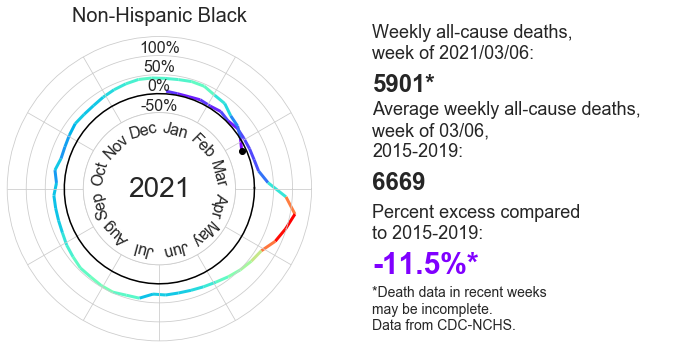

In [130]:
%%time
my_dpi = 99
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, polar=True)
ax2 = fig.add_subplot(122)
axes.flatten()[0]
data_list = []
data_list.append(initialize_axis_relative(ax=ax1, race_df='Non-Hispanic Black', 
                                 race_title='Non-Hispanic Black', high_val=100))

offset = 0.05
date = pd.to_datetime(data_list[0]['data']['Week Ending Date'].values[312])

weekly = data_list[0]['data']['Number of Deaths'].values[312]
expected = weekly - data_list[0]['data']['Difference from 2015-2019 to 2020'].values[312]
excess = data_list[0]['data']['Percent Difference from 2015-2019 to 2020'].values[312]

weekly_title = ax2.text(s='Weekly all-cause deaths,\nweek of ' + date.strftime("%Y/%m/%d") + ':',
                  x=0,y=0.85+offset, fontsize=18)
weekly_deaths = ax2.text(s=str(int(weekly)), x=0, y=0.75+offset, fontsize=24, fontweight='semibold')
expected_title = ax2.text(s='Average weekly all-cause deaths,\nweek of '+ date.strftime("%m/%d") + ',\n2015-2019:',
                    x=0, y=0.55+offset, fontsize=18)
expected_deaths = ax2.text(s=str(int(expected)), x=0, y=0.45+offset, fontsize=24, fontweight='semibold')
excess_title = ax2.text(s='Percent excess compared\nto 2015-2019:',
                    x=0, y=0.30+offset, fontsize=18)
excess_deaths = ax2.text(s=str(excess)+'%', x=0, y=0.19+offset, fontsize=30, 
                         color=plt.get_cmap('rainbow')(excess/100), fontweight='bold')
disclaimer = ax2.text(s='*Death data in recent weeks\nmay be incomplete.\nData from CDC-NCHS.',
                     x=0,y=0.02+offset, fontsize=14)
ax2.axis('off')

start_frame = 312 #312 starts at beginning of 2020.

for i in range(start_frame, len(data_list[0]['x'])+18): #Full range + ~2 seconds at 10 FPS
    clear_output(wait=True)
    save_i = i
    if i > len(data_list[0]['x'])-10:
        addendum = '*'
    else:
        addendum = ''
        
    for data_ele in data_list:
        
        
        if int(i) > len(data_ele['x'])-2:
            i = len(data_ele['x'])-2
        data_ele['lc_ax'].remove()
        
        date = pd.to_datetime(data_list[0]['data']['Week Ending Date'].values[i+1])
        weekly = data_list[0]['data']['Number of Deaths'].values[i+1]
        expected = weekly - data_list[0]['data']['Difference from 2015-2019 to 2020'].values[i+1]
        excess = data_list[0]['data']['Percent Difference from 2015-2019 to 2020'].values[i+1]
        
        weekly_title.set_text(s='Weekly all-cause deaths,\nweek of ' + date.strftime("%Y/%m/%d") + ':')
        weekly_deaths.set_text(s=str(int(weekly))+addendum)
        expected_title.set_text(s='Average weekly all-cause deaths,\nweek of '+ date.strftime("%m/%d") + ',\n2015-2019:')
        expected_deaths.set_text(s=str(int(expected)))
        excess_title.set_text(s='Percent excess compared\nto 2015-2019:')
        excess_deaths.set_text(s=str(excess)+'%'+addendum)
        excess_deaths.set_color(plt.get_cmap('rainbow')(excess/100))
        
        points = np.array([data_ele['x'].values[start_frame:i+2], 
                           data_ele['y'].values[start_frame:i+2]+data_ele['bottom']+data_ele['offset']]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        segments = segments
        lc = mpl.collections.LineCollection(segments, cmap=plt.get_cmap('rainbow'), zorder=0, alpha=1, norm=plt.Normalize(0,100))
        lc.set_array(data_ele['y'].values[start_frame:])
        lc.set_linewidth(3)
        data_ele['lc_ax'] = data_ele['ax'].add_collection(lc)
        
        data_ele['mark'].set_offsets([data_ele['x'].values[i+1], data_ele['y'].values[i+1]+data_ele['bottom']+data_ele['offset']])
        data_ele['text'].set_text(str(2014+int((-list(data_ele['x'])[i]+np.pi/2)/(2*np.pi))))
    plt.savefig('temp/' + str(save_i-start_frame) + '.jpg', dpi=my_dpi, quality=90, optimize=True, bbox_inches='tight', pad_inches=0.1)
    print(save_i)

#### Hispanic/Latino

391
Wall time: 1min 8s


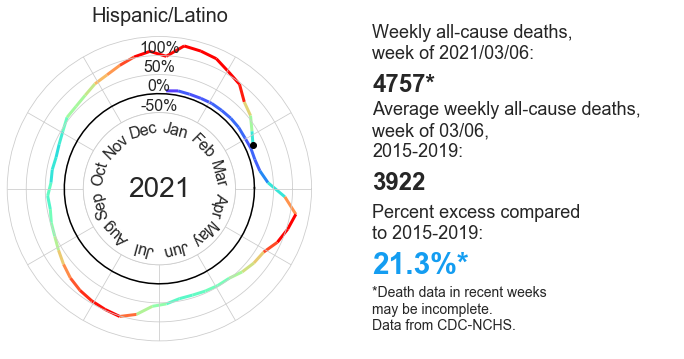

In [132]:
%%time
my_dpi = 99
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, polar=True)
ax2 = fig.add_subplot(122)
axes.flatten()[0]
data_list = []
data_list.append(initialize_axis_relative(ax=ax1, race_df='Hispanic', 
                                 race_title='Hispanic/Latino', high_val=100))

offset = 0.05
date = pd.to_datetime(data_list[0]['data']['Week Ending Date'].values[312])

weekly = data_list[0]['data']['Number of Deaths'].values[312]
expected = weekly - data_list[0]['data']['Difference from 2015-2019 to 2020'].values[312]
excess = data_list[0]['data']['Percent Difference from 2015-2019 to 2020'].values[312]

weekly_title = ax2.text(s='Weekly all-cause deaths,\nweek of ' + date.strftime("%Y/%m/%d") + ':',
                  x=0,y=0.85+offset, fontsize=18)
weekly_deaths = ax2.text(s=str(int(weekly)), x=0, y=0.75+offset, fontsize=24, fontweight='semibold')
expected_title = ax2.text(s='Average weekly all-cause deaths,\nweek of '+ date.strftime("%m/%d") + ',\n2015-2019:',
                    x=0, y=0.55+offset, fontsize=18)
expected_deaths = ax2.text(s=str(int(expected)), x=0, y=0.45+offset, fontsize=24, fontweight='semibold')
excess_title = ax2.text(s='Percent excess compared\nto 2015-2019:',
                    x=0, y=0.30+offset, fontsize=18)
excess_deaths = ax2.text(s=str(excess)+'%', x=0, y=0.19+offset, fontsize=30, 
                         color=plt.get_cmap('rainbow')(excess/100), fontweight='bold')
disclaimer = ax2.text(s='*Death data in recent weeks\nmay be incomplete.\nData from CDC-NCHS.',
                     x=0,y=0.02+offset, fontsize=14)
ax2.axis('off')

start_frame = 312 #312 starts at beginning of 2020.

for i in range(start_frame, 392):
    #Full range +3 seconds pause at 33 FPS = 462
    #Full range +3 seconds at 10 FPS = 404
    #Full range +3 seconds at 6 FPS = 392
    clear_output(wait=True)
    save_i = i
    if i > 365:
        addendum = '*'
    else:
        addendum = ''
        
    for data_ele in data_list:
        
        
        if int(i) > len(data_ele['x'])-2:
            i = len(data_ele['x'])-2
        data_ele['lc_ax'].remove()
        
        date = pd.to_datetime(data_list[0]['data']['Week Ending Date'].values[i+1])
        weekly = data_list[0]['data']['Number of Deaths'].values[i+1]
        expected = weekly - data_list[0]['data']['Difference from 2015-2019 to 2020'].values[i+1]
        excess = data_list[0]['data']['Percent Difference from 2015-2019 to 2020'].values[i+1]
        
        weekly_title.set_text(s='Weekly all-cause deaths,\nweek of ' + date.strftime("%Y/%m/%d") + ':')
        weekly_deaths.set_text(s=str(int(weekly))+addendum)
        expected_title.set_text(s='Average weekly all-cause deaths,\nweek of '+ date.strftime("%m/%d") + ',\n2015-2019:')
        expected_deaths.set_text(s=str(int(expected)))
        excess_title.set_text(s='Percent excess compared\nto 2015-2019:')
        excess_deaths.set_text(s=str(excess)+'%'+addendum)
        excess_deaths.set_color(plt.get_cmap('rainbow')(excess/100))
        
        points = np.array([data_ele['x'].values[start_frame:i+2], 
                           data_ele['y'].values[start_frame:i+2]+data_ele['bottom']+data_ele['offset']]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        segments = segments
        lc = mpl.collections.LineCollection(segments, cmap=plt.get_cmap('rainbow'), zorder=0, alpha=1, norm=plt.Normalize(0,100))
        lc.set_array(data_ele['y'].values[start_frame:])
        lc.set_linewidth(3)
        data_ele['lc_ax'] = data_ele['ax'].add_collection(lc)
        
        data_ele['mark'].set_offsets([data_ele['x'].values[i+1], data_ele['y'].values[i+1]+data_ele['bottom']+data_ele['offset']])
        data_ele['text'].set_text(str(2014+int((-list(data_ele['x'])[i]+np.pi/2)/(2*np.pi))))
    plt.savefig('temp/' + str(save_i-start_frame) + '.jpg', dpi=my_dpi, quality=90, optimize=True, bbox_inches='tight', pad_inches=0.1)
    print(save_i)

#### Non-Hispanic Asian

391
Wall time: 1min 10s


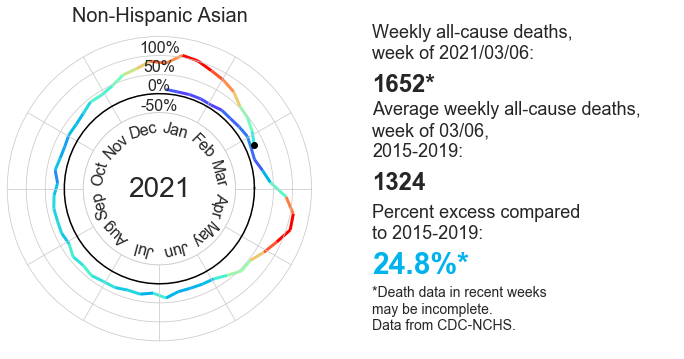

In [133]:
%%time
my_dpi = 99
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, polar=True)
ax2 = fig.add_subplot(122)
axes.flatten()[0]
data_list = []
data_list.append(initialize_axis_relative(ax=ax1, race_df='Non-Hispanic Asian', 
                                 race_title='Non-Hispanic Asian', high_val=100))

offset = 0.05
date = pd.to_datetime(data_list[0]['data']['Week Ending Date'].values[312])

weekly = data_list[0]['data']['Number of Deaths'].values[312]
expected = weekly - data_list[0]['data']['Difference from 2015-2019 to 2020'].values[312]
excess = data_list[0]['data']['Percent Difference from 2015-2019 to 2020'].values[312]

weekly_title = ax2.text(s='Weekly all-cause deaths,\nweek of ' + date.strftime("%Y/%m/%d") + ':',
                  x=0,y=0.85+offset, fontsize=18)
weekly_deaths = ax2.text(s=str(int(weekly)), x=0, y=0.75+offset, fontsize=24, fontweight='semibold')
expected_title = ax2.text(s='Average weekly all-cause deaths,\nweek of '+ date.strftime("%m/%d") + ',\n2015-2019:',
                    x=0, y=0.55+offset, fontsize=18)
expected_deaths = ax2.text(s=str(int(expected)), x=0, y=0.45+offset, fontsize=24, fontweight='semibold')
excess_title = ax2.text(s='Percent excess compared\nto 2015-2019:',
                    x=0, y=0.30+offset, fontsize=18)
excess_deaths = ax2.text(s=str(excess)+'%', x=0, y=0.19+offset, fontsize=30, 
                         color=plt.get_cmap('rainbow')(excess/100), fontweight='bold')
disclaimer = ax2.text(s='*Death data in recent weeks\nmay be incomplete.\nData from CDC-NCHS.',
                     x=0,y=0.02+offset, fontsize=14)
ax2.axis('off')

start_frame = 312 #312 starts at beginning of 2020.

for i in range(start_frame, 392):
    #Full range +3 seconds pause at 33 FPS = 462
    #Full range +3 seconds at 10 FPS = 404
    #Full range +3 seconds at 6 FPS = 392
    clear_output(wait=True)
    save_i = i
    if i > 365:
        addendum = '*'
    else:
        addendum = ''
        
    for data_ele in data_list:
        
        
        if int(i) > len(data_ele['x'])-2:
            i = len(data_ele['x'])-2
        data_ele['lc_ax'].remove()
        
        date = pd.to_datetime(data_list[0]['data']['Week Ending Date'].values[i+1])
        weekly = data_list[0]['data']['Number of Deaths'].values[i+1]
        expected = weekly - data_list[0]['data']['Difference from 2015-2019 to 2020'].values[i+1]
        excess = data_list[0]['data']['Percent Difference from 2015-2019 to 2020'].values[i+1]
        
        weekly_title.set_text(s='Weekly all-cause deaths,\nweek of ' + date.strftime("%Y/%m/%d") + ':')
        weekly_deaths.set_text(s=str(int(weekly))+addendum)
        expected_title.set_text(s='Average weekly all-cause deaths,\nweek of '+ date.strftime("%m/%d") + ',\n2015-2019:')
        expected_deaths.set_text(s=str(int(expected)))
        excess_title.set_text(s='Percent excess compared\nto 2015-2019:')
        excess_deaths.set_text(s=str(excess)+'%'+addendum)
        excess_deaths.set_color(plt.get_cmap('rainbow')(excess/100))
        
        points = np.array([data_ele['x'].values[start_frame:i+2], 
                           data_ele['y'].values[start_frame:i+2]+data_ele['bottom']+data_ele['offset']]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        segments = segments
        lc = mpl.collections.LineCollection(segments, cmap=plt.get_cmap('rainbow'), zorder=0, alpha=1, norm=plt.Normalize(0,100))
        lc.set_array(data_ele['y'].values[start_frame:])
        lc.set_linewidth(3)
        data_ele['lc_ax'] = data_ele['ax'].add_collection(lc)
        
        data_ele['mark'].set_offsets([data_ele['x'].values[i+1], data_ele['y'].values[i+1]+data_ele['bottom']+data_ele['offset']])
        data_ele['text'].set_text(str(2014+int((-list(data_ele['x'])[i]+np.pi/2)/(2*np.pi))))
    plt.savefig('temp/' + str(save_i-start_frame) + '.jpg', dpi=my_dpi, quality=90, optimize=True, bbox_inches='tight', pad_inches=0.1)
    print(save_i)

#### AI/AN

391
Wall time: 1min 12s


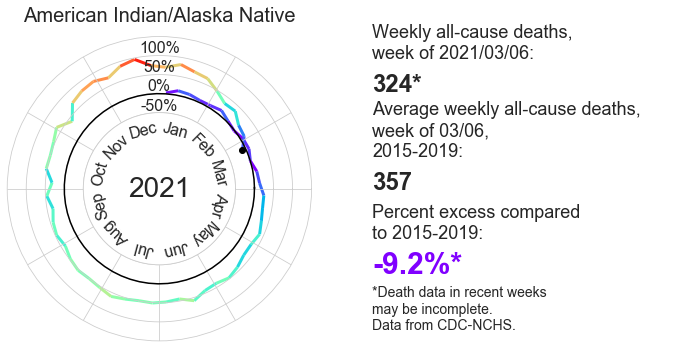

In [134]:
%%time
my_dpi = 99
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, polar=True)
ax2 = fig.add_subplot(122)
axes.flatten()[0]
data_list = []
data_list.append(initialize_axis_relative(ax=ax1, race_df='Non-Hispanic American Indian or Alaska Native', 
                                 race_title='American Indian/Alaska Native', high_val=100))

offset = 0.05
date = pd.to_datetime(data_list[0]['data']['Week Ending Date'].values[312])

weekly = data_list[0]['data']['Number of Deaths'].values[312]
expected = weekly - data_list[0]['data']['Difference from 2015-2019 to 2020'].values[312]
excess = data_list[0]['data']['Percent Difference from 2015-2019 to 2020'].values[312]

weekly_title = ax2.text(s='Weekly all-cause deaths,\nweek of ' + date.strftime("%Y/%m/%d") + ':',
                  x=0,y=0.85+offset, fontsize=18)
weekly_deaths = ax2.text(s=str(int(weekly)), x=0, y=0.75+offset, fontsize=24, fontweight='semibold')
expected_title = ax2.text(s='Average weekly all-cause deaths,\nweek of '+ date.strftime("%m/%d") + ',\n2015-2019:',
                    x=0, y=0.55+offset, fontsize=18)
expected_deaths = ax2.text(s=str(int(expected)), x=0, y=0.45+offset, fontsize=24, fontweight='semibold')
excess_title = ax2.text(s='Percent excess compared\nto 2015-2019:',
                    x=0, y=0.30+offset, fontsize=18)
excess_deaths = ax2.text(s=str(excess)+'%', x=0, y=0.19+offset, fontsize=30, 
                         color=plt.get_cmap('rainbow')(excess/100), fontweight='bold')
disclaimer = ax2.text(s='*Death data in recent weeks\nmay be incomplete.\nData from CDC-NCHS.',
                     x=0,y=0.02+offset, fontsize=14)
ax2.axis('off')

start_frame = 312 #312 starts at beginning of 2020.

for i in range(start_frame, 392):
    #Full range +3 seconds pause at 33 FPS = 462
    #Full range +3 seconds at 10 FPS = 404
    #Full range +3 seconds at 6 FPS = 392
    clear_output(wait=True)
    save_i = i
    if i > 365:
        addendum = '*'
    else:
        addendum = ''
        
    for data_ele in data_list:
        
        
        if int(i) > len(data_ele['x'])-2:
            i = len(data_ele['x'])-2
        data_ele['lc_ax'].remove()
        
        date = pd.to_datetime(data_list[0]['data']['Week Ending Date'].values[i+1])
        weekly = data_list[0]['data']['Number of Deaths'].values[i+1]
        expected = weekly - data_list[0]['data']['Difference from 2015-2019 to 2020'].values[i+1]
        excess = data_list[0]['data']['Percent Difference from 2015-2019 to 2020'].values[i+1]
        
        weekly_title.set_text(s='Weekly all-cause deaths,\nweek of ' + date.strftime("%Y/%m/%d") + ':')
        weekly_deaths.set_text(s=str(int(weekly))+addendum)
        expected_title.set_text(s='Average weekly all-cause deaths,\nweek of '+ date.strftime("%m/%d") + ',\n2015-2019:')
        expected_deaths.set_text(s=str(int(expected)))
        excess_title.set_text(s='Percent excess compared\nto 2015-2019:')
        excess_deaths.set_text(s=str(excess)+'%'+addendum)
        excess_deaths.set_color(plt.get_cmap('rainbow')(excess/100))
        
        points = np.array([data_ele['x'].values[start_frame:i+2], 
                           data_ele['y'].values[start_frame:i+2]+data_ele['bottom']+data_ele['offset']]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        segments = segments
        lc = mpl.collections.LineCollection(segments, cmap=plt.get_cmap('rainbow'), zorder=0, alpha=1, norm=plt.Normalize(0,100))
        lc.set_array(data_ele['y'].values[start_frame:])
        lc.set_linewidth(3)
        data_ele['lc_ax'] = data_ele['ax'].add_collection(lc)
        
        data_ele['mark'].set_offsets([data_ele['x'].values[i+1], data_ele['y'].values[i+1]+data_ele['bottom']+data_ele['offset']])
        data_ele['text'].set_text(str(2014+int((-list(data_ele['x'])[i]+np.pi/2)/(2*np.pi))))
    plt.savefig('temp/' + str(save_i-start_frame) + '.jpg', dpi=my_dpi, quality=90, optimize=True, bbox_inches='tight', pad_inches=0.1)
    print(save_i)

391
Wall time: 1min 27s


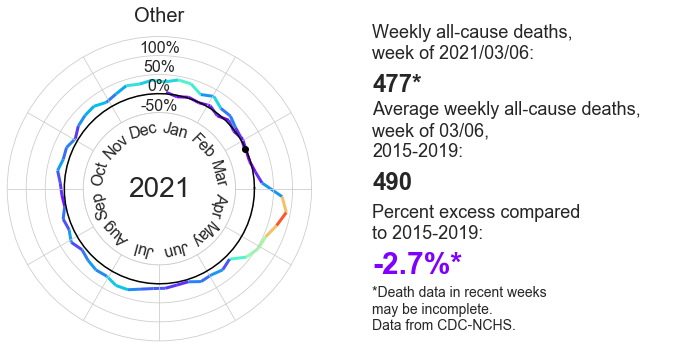

In [135]:
%%time
my_dpi = 99
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, polar=True)
ax2 = fig.add_subplot(122)
axes.flatten()[0]
data_list = []
data_list.append(initialize_axis_relative(ax=ax1, race_df='Other', 
                                 race_title='Other', high_val=100))

offset = 0.05
date = pd.to_datetime(data_list[0]['data']['Week Ending Date'].values[312])

weekly = data_list[0]['data']['Number of Deaths'].values[312]
expected = weekly - data_list[0]['data']['Difference from 2015-2019 to 2020'].values[312]
excess = data_list[0]['data']['Percent Difference from 2015-2019 to 2020'].values[312]

weekly_title = ax2.text(s='Weekly all-cause deaths,\nweek of ' + date.strftime("%Y/%m/%d") + ':',
                  x=0,y=0.85+offset, fontsize=18)
weekly_deaths = ax2.text(s=str(int(weekly)), x=0, y=0.75+offset, fontsize=24, fontweight='semibold')
expected_title = ax2.text(s='Average weekly all-cause deaths,\nweek of '+ date.strftime("%m/%d") + ',\n2015-2019:',
                    x=0, y=0.55+offset, fontsize=18)
expected_deaths = ax2.text(s=str(int(expected)), x=0, y=0.45+offset, fontsize=24, fontweight='semibold')
excess_title = ax2.text(s='Percent excess compared\nto 2015-2019:',
                    x=0, y=0.30+offset, fontsize=18)
excess_deaths = ax2.text(s=str(excess)+'%', x=0, y=0.19+offset, fontsize=30, 
                         color=plt.get_cmap('rainbow')(excess/100), fontweight='bold')
disclaimer = ax2.text(s='*Death data in recent weeks\nmay be incomplete.\nData from CDC-NCHS.',
                     x=0,y=0.02+offset, fontsize=14)
ax2.axis('off')

start_frame = 312 #312 starts at beginning of 2020.

for i in range(start_frame, 392):
    #Full range +3 seconds pause at 33 FPS = 462
    #Full range +3 seconds at 10 FPS = 404
    #Full range +3 seconds at 6 FPS = 392
    clear_output(wait=True)
    save_i = i
    if i > 365:
        addendum = '*'
    else:
        addendum = ''
        
    for data_ele in data_list:
        
        
        if int(i) > len(data_ele['x'])-2:
            i = len(data_ele['x'])-2
        data_ele['lc_ax'].remove()
        
        date = pd.to_datetime(data_list[0]['data']['Week Ending Date'].values[i+1])
        weekly = data_list[0]['data']['Number of Deaths'].values[i+1]
        expected = weekly - data_list[0]['data']['Difference from 2015-2019 to 2020'].values[i+1]
        excess = data_list[0]['data']['Percent Difference from 2015-2019 to 2020'].values[i+1]
        
        weekly_title.set_text(s='Weekly all-cause deaths,\nweek of ' + date.strftime("%Y/%m/%d") + ':')
        weekly_deaths.set_text(s=str(int(weekly))+addendum)
        expected_title.set_text(s='Average weekly all-cause deaths,\nweek of '+ date.strftime("%m/%d") + ',\n2015-2019:')
        expected_deaths.set_text(s=str(int(expected)))
        excess_title.set_text(s='Percent excess compared\nto 2015-2019:')
        excess_deaths.set_text(s=str(excess)+'%'+addendum)
        excess_deaths.set_color(plt.get_cmap('rainbow')(excess/100))
        
        points = np.array([data_ele['x'].values[start_frame:i+2], 
                           data_ele['y'].values[start_frame:i+2]+data_ele['bottom']+data_ele['offset']]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        segments = segments
        lc = mpl.collections.LineCollection(segments, cmap=plt.get_cmap('rainbow'), zorder=0, alpha=1, norm=plt.Normalize(0,100))
        lc.set_array(data_ele['y'].values[start_frame:])
        lc.set_linewidth(3)
        data_ele['lc_ax'] = data_ele['ax'].add_collection(lc)
        
        data_ele['mark'].set_offsets([data_ele['x'].values[i+1], data_ele['y'].values[i+1]+data_ele['bottom']+data_ele['offset']])
        data_ele['text'].set_text(str(2014+int((-list(data_ele['x'])[i]+np.pi/2)/(2*np.pi))))
    plt.savefig('temp/' + str(save_i-start_frame) + '.jpg', dpi=my_dpi, quality=90, optimize=True, bbox_inches='tight', pad_inches=0.1)
    print(save_i)